<a href="https://colab.research.google.com/github/Fayli775/INFOSYS722-Iteration4/blob/main/04_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:

from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

# Load prepared data
in_parquet = "/content/drive/MyDrive/722/output/03_prepared.parquet"
df4 = spark.read.parquet(in_parquet)

def pick(df_, *cands):
    for c in cands:
        if c in df_.columns:
            return c
    return None

# Resolve column names
COL_YEAR    = pick(df4, "year", "Year")
COL_MONTH   = pick(df4, "month", "Month")
COL_DAY     = pick(df4, "day", "Day")
COL_HOUR    = pick(df4, "hour", "Hour")
COL_WEEKDAY = pick(df4, "weekday", "Weekday")
COL_REGION  = pick(df4, "region_name", "Region Name")
COL_LANE    = pick(df4, "lane_number", "Lane Number")
COL_FLOW    = pick(df4, "flow_direction", "Flow Direction")
COL_CLASS   = pick(df4, "class_weight", "Class Weight")
COL_HOL     = pick(df4, "is_holiday", "Is_Holiday")
COL_TARGET  = pick(df4, "traffic_count", "Traffic Count")

print(f"Input dataset: {df4.count():,} records, {len(df4.columns)} columns")

# Feature screening thresholds
THRESH_MISS_MAX = 0.50      # max missing share
THRESH_DOM_MAX  = 0.90      # max dominant category share
THRESH_CAT_DENS = 0.95      # max categories as % of rows
THRESH_CV_MIN   = 0.10      # min coefficient of variation
THRESH_UNIQUE_MIN_NUMERIC = 3

n_rows = df4.count()
candidates = [c for c in [COL_YEAR, COL_MONTH, COL_DAY, COL_HOUR, COL_WEEKDAY,
                         COL_REGION, COL_LANE, COL_FLOW, COL_CLASS, COL_HOL] if c]

# Build diagnostics for each feature
diag = []
dtypes = dict(df4.dtypes)
for c in candidates:
    miss = df4.filter(col(c).isNull()).count() / max(n_rows, 1)
    nunq = df4.select(c).distinct().count()
    is_num = dtypes.get(c, "").lower() in ("int","bigint","double","float","decimal","smallint","long")

    dom, cv = None, None
    if not is_num:
        row = df4.groupBy(c).count().orderBy(F.desc("count")).limit(1).collect()
        dom = (row[0]["count"] / n_rows) if row else 0.0
    else:
        st = df4.select(F.mean(col(c)).alias("m"), F.stddev(col(c)).alias("s")).first()
        m = float(st["m"]) if st["m"] is not None else 0.0
        s = float(st["s"]) if st["s"] is not None else 0.0
        cv = (s / m) if (m != 0.0) else 0.0
    diag.append((c, miss, nunq, dom, cv, is_num))

# Apply screening rules
keep, drop = [], []
for c, miss, nunq, dom, cv, is_num in diag:
    reason = None
    if miss > THRESH_MISS_MAX:
        reason = f"missing>{THRESH_MISS_MAX}"
    elif not is_num:
        if dom is not None and dom > THRESH_DOM_MAX:
            reason = f"dominant_category>{THRESH_DOM_MAX}"
        elif nunq / max(n_rows,1) > THRESH_CAT_DENS:
            reason = f"category_density>{THRESH_CAT_DENS}"
    else:
        if nunq < THRESH_UNIQUE_MIN_NUMERIC:
            reason = f"unique_values<{THRESH_UNIQUE_MIN_NUMERIC}"
        elif cv is not None and cv < THRESH_CV_MIN:
            reason = f"coefficient_of_variation<{THRESH_CV_MIN}"

    if reason:
        drop.append((c, reason))
    else:
        keep.append(c)

print(f"\nFeature Screening Results:")
print(f"Retained: {len(keep)} features - {keep}")
print(f"Dropped: {len(drop)} features - {[f'{c} ({reason})' for c, reason in drop]}")

# Create reduced dataset
reduced_cols = [COL_TARGET] + keep
df4_reduced = df4.select(*reduced_cols)

Input dataset: 1,922,734 records, 12 columns

Feature Screening Results:
Retained: 6 features - ['month', 'day', 'weekday', 'Lane Number', 'Flow Direction', 'Class Weight']
Dropped: 4 features - ['year (coefficient_of_variation<0.1)', 'hour (unique_values<3)', 'Region Name (dominant_category>0.9)', 'is_holiday (unique_values<3)']


RandomForest Feature Importance Ranking:
  1. Class Weight         0.8644
  2. Flow Direction       0.0756
  3. Lane Number          0.0446
  4. weekday              0.0121
  5. month                0.0022
  6. day                  0.0011

Final Feature Selection (importance ≥ 0.01):
Selected: ['Class Weight', 'Flow Direction', 'Lane Number', 'weekday']
Feature reduction: 10 → 4 (60.0% reduction)


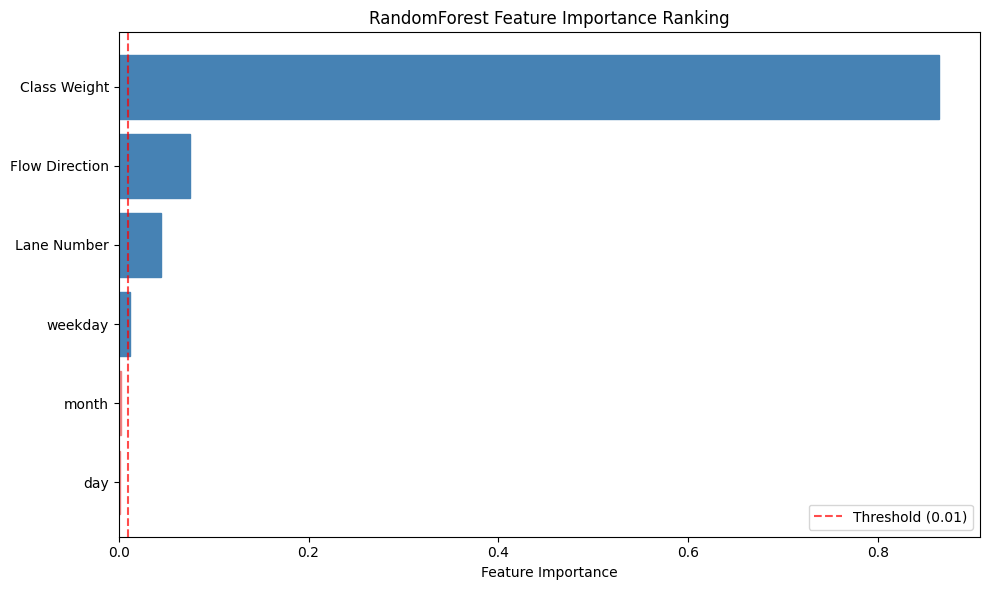

In [15]:
import matplotlib.pyplot as plt

# Feature importance ranking using RandomForest
cat_cols = [c for c in [COL_FLOW, COL_CLASS, COL_WEEKDAY] if c and c in df4_reduced.columns]
num_cols = [c for c in [COL_LANE, COL_MONTH, COL_DAY] if c and c in df4_reduced.columns]

stages = []
indexed_cols = []

# String indexing for categorical features
for c in cat_cols:
    indexed_col = c + "_idx"
    stages.append(StringIndexer(inputCol=c, outputCol=indexed_col, handleInvalid="keep"))
    indexed_cols.append(indexed_col)

# Feature vector assembly and RandomForest training
all_feature_cols = num_cols + indexed_cols
assembler = VectorAssembler(inputCols=all_feature_cols, outputCol="features")
rf = RandomForestRegressor(featuresCol="features", labelCol=COL_TARGET, numTrees=50, maxDepth=8, seed=42)
stages.extend([assembler, rf])

# Fit pipeline
pipe = Pipeline(stages=stages)
fitted_pipe = pipe.fit(df4_reduced)
rf_model = fitted_pipe.stages[-1]

# Extract and rank feature importances
importances = rf_model.featureImportances.toArray()
imp_pairs = list(zip(all_feature_cols, importances))
imp_pairs_sorted = sorted(imp_pairs, key=lambda x: x[1], reverse=True)

print(f"RandomForest Feature Importance Ranking:")
for i, (feature, importance) in enumerate(imp_pairs_sorted, 1):
    original_name = feature.replace('_idx', '') if feature.endswith('_idx') else feature
    print(f"  {i}. {original_name:<20} {importance:.4f}")

# Apply importance threshold for final feature selection
IMPORTANCE_THRESHOLD = 0.01
important_features = [feature for feature, importance in imp_pairs_sorted if importance >= IMPORTANCE_THRESHOLD]
final_feature_cols = [f.replace('_idx', '') if f.endswith('_idx') else f for f in important_features]

print(f"\nFinal Feature Selection (importance ≥ {IMPORTANCE_THRESHOLD}):")
print(f"Selected: {final_feature_cols}")
print(f"Feature reduction: {len(candidates)} → {len(final_feature_cols)} ({(1-len(final_feature_cols)/len(candidates))*100:.1f}% reduction)")

# Visualization: Feature Importance
feature_names = [f.replace('_idx', '') if f.endswith('_idx') else f for f, _ in imp_pairs_sorted]
importance_values = [imp for _, imp in imp_pairs_sorted]

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(feature_names)), importance_values)
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel('Feature Importance')
plt.title('RandomForest Feature Importance Ranking')
plt.gca().invert_yaxis()

# Color bars based on importance threshold
for i, bar in enumerate(bars):
    if importance_values[i] >= IMPORTANCE_THRESHOLD:
        bar.set_color('steelblue')
    else:
        bar.set_color('lightcoral')

plt.axvline(x=IMPORTANCE_THRESHOLD, color='red', linestyle='--', alpha=0.7, label=f'Threshold ({IMPORTANCE_THRESHOLD})')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/722/output/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Save importance results
imp_data = [(i, f.replace('_idx', '') if f.endswith('_idx') else f, float(imp))
            for i, (f, imp) in enumerate(imp_pairs_sorted, 1)]
imp_df = spark.createDataFrame(imp_data, ["rank", "feature", "importance"])
imp_df.coalesce(1).write.mode("overwrite").option("header", True).csv("/content/drive/MyDrive/722/output/04_feature_importance.csv")

In [16]:
# Create final dataset with selected features only
df4_final = df4_reduced.select([COL_TARGET] + final_feature_cols)

# Remove non-positive traffic counts
df4v = df4_final.filter(col(COL_TARGET) > 0)
positive_records = df4v.count()
total_records = df4_final.count()

# Weekday filtering (if weekday is retained)
if COL_WEEKDAY in final_feature_cols:
    dtype = dict(df4v.dtypes).get(COL_WEEKDAY, "").lower()
    if dtype in ("int","bigint","smallint","long"):
        wk_cond = col(COL_WEEKDAY).between(2,6) | col(COL_WEEKDAY).between(1,5)
    else:
        wk_cond = ~col(COL_WEEKDAY).isin("Sat", "Sun", "Saturday", "Sunday")

    df4_model_main = df4v.filter(wk_cond)
    weekday_records = df4_model_main.count()
else:
    df4_model_main = df4v
    weekday_records = positive_records

df4_model_full = df4v

print(f"Vertical Reduction Results:")
print(f"Original records: {df4.count():,}")
print(f"After positive filtering: {positive_records:,}")
print(f"After weekday filtering: {weekday_records:,}")
print(f"Total reduction: {(1 - weekday_records/df4.count())*100:.1f}%")

# Save final datasets
out_main = "/content/drive/MyDrive/722/output/04_reduced_main.parquet"
out_full = "/content/drive/MyDrive/722/output/04_reduced_full.parquet"

df4_model_main.write.mode("overwrite").parquet(out_main)
df4_model_full.write.mode("overwrite").parquet(out_full)

print(f"\nData Reduction Complete!")
print(f"Final modeling dataset: {weekday_records:,} records, {len(final_feature_cols)} features")
print(f"Saved: {out_main}")
print(f"Features: {final_feature_cols}")

Vertical Reduction Results:
Original records: 1,922,734
After positive filtering: 1,918,255
After weekday filtering: 1,371,877
Total reduction: 28.6%

Data Reduction Complete!
Final modeling dataset: 1,371,877 records, 4 features
Saved: /content/drive/MyDrive/722/output/04_reduced_main.parquet
Features: ['Class Weight', 'Flow Direction', 'Lane Number', 'weekday']


In [19]:
print(f"\nFinal Dataset Sample:")
print(f"Schema: {df4_model_main.columns}")
print(f"Data types:")
for col_name, col_type in df4_model_main.dtypes:
    print(f"  {col_name}: {col_type}")

print(f"\nSample Records (first 10 rows):")
df4_model_main.show(10, truncate=False)

print(f"\nBasic Statistics for Final Dataset:")
df4_model_main.describe().show()

# Optional: Show distribution of categorical variables
print(f"\nCategorical Variable Distributions:")
if 'Flow Direction' in df4_model_main.columns:
    print("Flow Direction distribution:")
    df4_model_main.groupBy('Flow Direction').count().orderBy('count', ascending=False).show()

if 'Class Weight' in df4_model_main.columns:
    print("Class Weight distribution:")
    df4_model_main.groupBy('Class Weight').count().orderBy('count', ascending=False).show()

if 'weekday' in df4_model_main.columns:
    print("Weekday distribution:")
    df4_model_main.groupBy('weekday').count().orderBy('weekday').show()


Final Dataset Sample:
Schema: ['Traffic Count', 'Class Weight', 'Flow Direction', 'Lane Number', 'weekday']
Data types:
  Traffic Count: double
  Class Weight: string
  Flow Direction: string
  Lane Number: int
  weekday: string

Sample Records (first 10 rows):
+-------------+------------+--------------+-----------+-------+
|Traffic Count|Class Weight|Flow Direction|Lane Number|weekday|
+-------------+------------+--------------+-----------+-------+
|18585.0      |Light       |2             |2          |Thu    |
|924.0        |Heavy       |1             |1          |Thu    |
|18508.0      |Light       |1             |1          |Thu    |
|930.0        |Heavy       |2             |2          |Thu    |
|938.0        |Heavy       |2             |2          |Fri    |
|18775.5      |Light       |1             |1          |Fri    |
|18914.0      |Light       |2             |2          |Fri    |
|943.5        |Heavy       |1             |1          |Fri    |
|866.0        |Heavy       |2    

Starting data projection on 1,371,877 records

Traffic Count Distribution:
  Mean: 7682.25
  Std Dev: 7153.79
  Skewness indicated by mean/std ratio: 1.07

Log-Transformed Traffic Count Distribution:
  Mean: 8.10
  Std Dev: 1.65


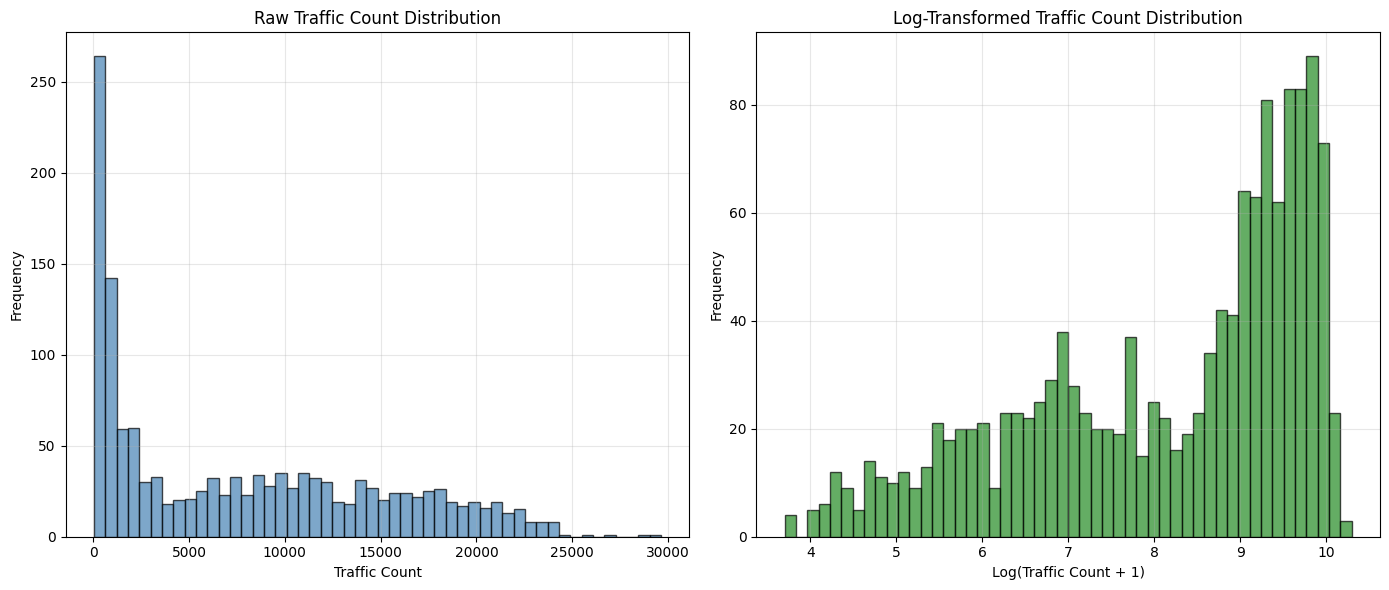


Log transformation successfully applied
New variable created: Log_Traffic_Count = log(Traffic Count + 1)
Distribution comparison saved as Figure 4-6


In [20]:
# Data Distribution Analysis and Log Transformation

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import log, col, mean, stddev

# Load the final reduced dataset
df_main = spark.read.parquet("/content/drive/MyDrive/722/output/04_reduced_main.parquet")

print(f"Starting data projection on {df_main.count():,} records")

# Analyze target variable distribution
target_stats = df_main.select(
    mean(col(COL_TARGET)).alias("mean"),
    stddev(col(COL_TARGET)).alias("stddev"),
).collect()[0]

print(f"\nTraffic Count Distribution:")
print(f"  Mean: {target_stats['mean']:.2f}")
print(f"  Std Dev: {target_stats['stddev']:.2f}")
print(f"  Skewness indicated by mean/std ratio: {target_stats['mean']/target_stats['stddev']:.2f}")

# Create log-transformed target variable
# Using log(x + 1) to handle any zero values gracefully
df_projected = df_main.withColumn("Log_Traffic_Count", log(col(COL_TARGET) + 1))

# Calculate log-transformed statistics
log_stats = df_projected.select(
    mean(col("Log_Traffic_Count")).alias("log_mean"),
    stddev(col("Log_Traffic_Count")).alias("log_stddev"),
).collect()[0]

print(f"\nLog-Transformed Traffic Count Distribution:")
print(f"  Mean: {log_stats['log_mean']:.2f}")
print(f"  Std Dev: {log_stats['log_stddev']:.2f}")

# Sample data for visualization
sample_data = df_projected.sample(0.001, seed=42).toPandas()  # 0.1% sample for plotting

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Raw traffic count histogram
ax1.hist(sample_data[COL_TARGET], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Traffic Count')
ax1.set_ylabel('Frequency')
ax1.set_title('Raw Traffic Count Distribution')
ax1.grid(True, alpha=0.3)

# Log-transformed histogram
ax2.hist(sample_data['Log_Traffic_Count'], bins=50, alpha=0.7, color='forestgreen', edgecolor='black')
ax2.set_xlabel('Log(Traffic Count + 1)')
ax2.set_ylabel('Frequency')
ax2.set_title('Log-Transformed Traffic Count Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/722/output/traffic_count_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nLog transformation successfully applied")
print(f"New variable created: Log_Traffic_Count = log(Traffic Count + 1)")
print(f"Distribution comparison saved as Figure 4-6")

In [21]:
# Z-Score Standardization of Continuous Features

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

# Identify continuous features for standardization
continuous_features = []
for col_name in df_projected.columns:
    if col_name not in [COL_TARGET, 'Log_Traffic_Count']:  # Exclude target variables
        dtype = dict(df_projected.dtypes).get(col_name, "").lower()
        if dtype in ("int","bigint","double","float","decimal","smallint","long"):
            # Check if it's truly continuous (more than a few unique values)
            unique_count = df_projected.select(col_name).distinct().count()
            if unique_count > 5:  # Threshold for continuous vs discrete
                continuous_features.append(col_name)

print(f"Continuous features identified for standardization: {continuous_features}")

# Apply z-score standardization to continuous features
standardized_features = []
if continuous_features:
    for feature in continuous_features:
        # Calculate mean and standard deviation
        stats = df_projected.select(
            mean(col(feature)).alias("mean"),
            stddev(col(feature)).alias("stddev")
        ).collect()[0]

        feature_mean = float(stats["mean"])
        feature_std = float(stats["stddev"])

        print(f"\n{feature} - Original: Mean={feature_mean:.3f}, Std={feature_std:.3f}")

        # Create standardized version: (x - mean) / std
        standardized_col = f"{feature}_standardized"
        df_projected = df_projected.withColumn(
            standardized_col,
            (col(feature) - feature_mean) / feature_std
        )
        standardized_features.append(standardized_col)

        # Verify standardization
        std_stats = df_projected.select(
            mean(col(standardized_col)).alias("std_mean"),
            stddev(col(standardized_col)).alias("std_stddev")
        ).collect()[0]

        print(f"{standardized_col} - Standardized: Mean={float(std_stats['std_mean']):.6f}, Std={float(std_stats['std_stddev']):.6f}")

print(f"\nStandardization complete. Created standardized versions:")
for i, (original, standardized) in enumerate(zip(continuous_features, standardized_features), 1):
    print(f"  {i}. {original} → {standardized}")

# Keep categorical features as-is (no standardization needed)
categorical_features = []
for col_name in df_projected.columns:
    if col_name not in [COL_TARGET, 'Log_Traffic_Count'] + continuous_features + standardized_features:
        dtype = dict(df_projected.dtypes).get(col_name, "").lower()
        if dtype in ("string", "boolean") or col_name in ['weekday', 'Flow Direction', 'Class Weight']:
            categorical_features.append(col_name)

print(f"\nCategorical features (no standardization): {categorical_features}")

# Create final feature list for modeling
modeling_features = standardized_features + categorical_features
print(f"\nFinal modeling features: {modeling_features}")
print(f"Target variables available: [{COL_TARGET}, Log_Traffic_Count]")

Continuous features identified for standardization: []

Standardization complete. Created standardized versions:

Categorical features (no standardization): ['Class Weight', 'Flow Direction', 'weekday']

Final modeling features: ['Class Weight', 'Flow Direction', 'weekday']
Target variables available: [Traffic Count, Log_Traffic_Count]


In [23]:
#  Data Quality Validation and Export

from pyspark.sql.functions import isnan, isnull, when, count, col

# Data quality assessment after projection

# Check for missing values in all columns
missing_analysis = []
for column in df_projected.columns:
    missing_count = df_projected.filter(col(column).isNull() | isnan(col(column))).count()
    total_count = df_projected.count()
    missing_pct = (missing_count / total_count) * 100
    missing_analysis.append((column, missing_count, missing_pct))

print(f"\nMissing Value Analysis:")
for col_name, missing_count, missing_pct in missing_analysis:
    status = "✓" if missing_count == 0 else "⚠"
    print(f"  {status} {col_name:<25} Missing: {missing_count:>6} ({missing_pct:>5.2f}%)")

# Outlier detection for standardized features (values beyond ±3 standard deviations)
print(f"\nOutlier Analysis (|z-score| > 3):")
outlier_summary = []
for feature in standardized_features:
    outliers = df_projected.filter(
        (col(feature) > 3) | (col(feature) < -3)
    ).count()
    outlier_pct = (outliers / df_projected.count()) * 100
    outlier_summary.append((feature, outliers, outlier_pct))
    print(f"  {feature:<30} Outliers: {outliers:>6} ({outlier_pct:>5.2f}%)")

# Summary statistics for final dataset
print(f"\nFinal Dataset Summary:")
print(f"  Total records: {df_projected.count():,}")
print(f"  Total features: {len(df_projected.columns)}")
print(f"  Modeling features: {len(modeling_features)}")
print(f"  Target variables: 2 (original + log-transformed)")
print(f"  Standardized continuous features: {len(standardized_features)}")
print(f"  Categorical features: {len(categorical_features)}")

# Create final modeling dataset with selected columns
final_columns = [COL_TARGET, 'Log_Traffic_Count'] + modeling_features
df_final_modeling = df_projected.select(*final_columns)

print(f"\nFinal Modeling Dataset Schema:")
for i, (col_name, col_type) in enumerate(df_final_modeling.dtypes, 1):
    print(f"  {i:2d}. {col_name:<30} {col_type}")

# Export final dataset
print(f"\nExporting Final Dataset:")
output_parquet = "/content/drive/MyDrive/722/output/05_projected_final.parquet"
output_csv = "/content/drive/MyDrive/722/output/05_projected_final.csv"

# Save as Parquet (efficient for Spark)
df_final_modeling.write.mode("overwrite").parquet(output_parquet)
print(f"  ✓ Parquet saved: {output_parquet}")

# Save as CSV (for compatibility with other tools)
df_final_modeling.coalesce(1).write.mode("overwrite")\
    .option("header", "true")\
    .option("timestampFormat", "yyyy-MM-dd HH:mm:ss")\
    .csv(output_csv)
print(f"  ✓ CSV saved: {output_csv}")

# Display sample of final dataset
print(f"\nFinal Dataset Sample (Figure 4-7):")
df_final_modeling.show(5, truncate=False)


Missing Value Analysis:
  ✓ Traffic Count             Missing:      0 ( 0.00%)
  ✓ Class Weight              Missing:      0 ( 0.00%)
  ✓ Flow Direction            Missing:      0 ( 0.00%)
  ✓ Lane Number               Missing:      0 ( 0.00%)
  ✓ weekday                   Missing:      0 ( 0.00%)
  ✓ Log_Traffic_Count         Missing:      0 ( 0.00%)

Outlier Analysis (|z-score| > 3):

Final Dataset Summary:
  Total records: 1,371,877
  Total features: 6
  Modeling features: 3
  Target variables: 2 (original + log-transformed)
  Standardized continuous features: 0
  Categorical features: 3

Final Modeling Dataset Schema:
   1. Traffic Count                  double
   2. Log_Traffic_Count              double
   3. Class Weight                   string
   4. Flow Direction                 string
   5. weekday                        string

Exporting Final Dataset:
  ✓ Parquet saved: /content/drive/MyDrive/722/output/05_projected_final.parquet
  ✓ CSV saved: /content/drive/MyDrive/722/o